## Sales data analysis and prediction using Neural Network


---
* Data: https://www.kaggle.com/rohitsahoo/sales-forecasting 

* Sequential Model and Functional API

---

In [267]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import r2_score

print(tf.__version__)
print(keras.__version__)

1.14.0
2.2.4-tf


In [268]:
data = pd.read_csv('train.csv')

In [269]:
data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [270]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

## Preprocessing

In [271]:
def encode_date(df, column):
    df = df.copy()
    df[column] = pd.to_datetime(df[column], dayfirst=True)
    df[column + '_day'] = df[column].apply(lambda x: x.day)
    df[column + '_month'] = df[column].apply(lambda x: x.month)
    df[column + '_year'] = df[column].apply(lambda x: x.year)
    df = df.drop(column, axis=1)
    return df

def get_dummies(df, column):
    df = df.copy()
    dummies = pd.get_dummies(df[column], prefix=column)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)
    return df

In [272]:
def preprocess_inputs(df):
    df= df.copy()
    
    #drop unnecessary columns
    df = df.drop(['Row ID', 'Country', 'Customer Name', 'Product Name'], axis=1)
    
    #drop customer specific features
    df = df.drop(['Customer ID', 'Order ID'], axis=1)
    
    # get dates
    df = encode_date(df, column='Order Date')
    df = encode_date(df, column='Ship Date')
    
    #get dummies 
    for column in ['Ship Mode', 'Segment', 'City' , 'State', 'Postal Code', 'Region', 'Product ID' ,'Category', 'Sub-Category']:
        df = get_dummies(df, column=column)
    
    # split df into X and Y
    y= df['Sales']
    X = df.drop('Sales', axis=1)
    
    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=.80, shuffle=True,random_state=1)
    
    # scale X , Note: we only fit the scaler to x_train
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), columns=X.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
    
    return X_train, X_test, y_train, y_test
    

In [273]:
X_train, X_test, y_train, y_test = preprocess_inputs(data)

In [274]:
#{column: len(X[column].unique()) for column in X.columns}

In [275]:
for i in X_train, X_test, y_train, y_test:
    print(i.shape)

(7840, 3102)
(1960, 3102)
(7840,)
(1960,)


In [276]:
# here we have our scaled training dataset, mean close to 0 and std deviation 1
X_train.describe()

,Order Date_day,Order Date_month,Order Date_year,Ship Date_day,Ship Date_month,Ship Date_year,Ship Mode_First Class,Ship Mode_Same Day,Ship Mode_Second Class,Ship Mode_Standard Class,...,Sub-Category_Envelopes,Sub-Category_Fasteners,Sub-Category_Furnishings,Sub-Category_Labels,Sub-Category_Machines,Sub-Category_Paper,Sub-Category_Phones,Sub-Category_Storage,Sub-Category_Supplies,Sub-Category_Tables
count,7.840000e+03,7.840000e+03,7.840000e+03,7.840000e+03,7.840000e+03,7.840000e+03,7.840000e+03,7.840000e+03,7.840000e+03,7.840000e+03,...,7.840000e+03,7.840000e+03,7.840000e+03,7.840000e+03,7.840000e+03,7.840000e+03,7.840000e+03,7.840000e+03,7.840000e+03,7.840000e+03
mean,1.132881e-17,-1.160070e-16,-8.082696e-14,-2.356392e-17,9.334936e-17,-2.723264e-14,-6.072240e-17,-3.942425e-17,-4.440892e-17,-6.887914e-17,...,-5.211251e-18,-8.700523e-17,4.803414e-17,-3.534588e-17,3.625218e-18,9.969350e-18,-8.360659e-17,7.431697e-17,-2.718914e-18,2.537653e-17
std,1.000064e+00,1.000064e+00,1.000064e+00,1.000064e+00,1.000064e+00,1.000064e+00,1.000064e+00,1.000064e+00,1.000064e+00,1.000064e+00,...,1.000064e+00,1.000064e+00,1.000064e+00,1.000064e+00,1.000064e+00,1.000064e+00,1.000064e+00,1.000064e+00,1.000064e+00,1.000064e+00
min,-1.656664e+00,-2.074014e+00,-1.522877e+00,-1.693765e+00,-2.019916e+00,-1.534851e+00,-4.292901e-01,-2.487950e-01,-4.874106e-01,-1.209900e+00,...,-1.646787e-01,-1.484285e-01,-3.228395e-01,-1.928062e-01,-1.107519e-01,-4.029175e-01,-3.136031e-01,-3.019307e-01,-1.372713e-01,-1.840967e-01
25%,-8.568035e-01,-8.559249e-01,-6.336056e-01,-8.992338e-01,-8.215928e-01,-6.465272e-01,-4.292901e-01,-2.487950e-01,-4.874106e-01,-1.209900e+00,...,-1.646787e-01,-1.484285e-01,-3.228395e-01,-1.928062e-01,-1.107519e-01,-4.029175e-01,-3.136031e-01,-3.019307e-01,-1.372713e-01,-1.840967e-01
50%,-5.694339e-02,3.621639e-01,2.556654e-01,8.802391e-03,3.767305e-01,2.417962e-01,-4.292901e-01,-2.487950e-01,-4.874106e-01,8.265142e-01,...,-1.646787e-01,-1.484285e-01,-3.228395e-01,-1.928062e-01,-1.107519e-01,-4.029175e-01,-3.136031e-01,-3.019307e-01,-1.372713e-01,-1.840967e-01
75%,8.571824e-01,9.712083e-01,1.144936e+00,9.168386e-01,9.758922e-01,1.130120e+00,-4.292901e-01,-2.487950e-01,-4.874106e-01,8.265142e-01,...,-1.646787e-01,-1.484285e-01,-3.228395e-01,-1.928062e-01,-1.107519e-01,-4.029175e-01,-3.136031e-01,-3.019307e-01,-1.372713e-01,-1.840967e-01
max,1.771308e+00,1.275730e+00,1.144936e+00,1.711370e+00,1.275473e+00,2.018443e+00,2.329427e+00,4.019373e+00,2.051658e+00,8.265142e-01,...,6.072429e+00,6.737250e+00,3.097514e+00,5.186555e+00,9.029192e+00,2.481898e+00,3.188744e+00,3.312018e+00,7.284845e+00,5.431928e+00


In [277]:
X_train.head()

,Order Date_day,Order Date_month,Order Date_year,Ship Date_day,Ship Date_month,Ship Date_year,Ship Mode_First Class,Ship Mode_Same Day,Ship Mode_Second Class,Ship Mode_Standard Class,...,Sub-Category_Envelopes,Sub-Category_Fasteners,Sub-Category_Furnishings,Sub-Category_Labels,Sub-Category_Machines,Sub-Category_Paper,Sub-Category_Phones,Sub-Category_Storage,Sub-Category_Supplies,Sub-Category_Tables
0,-0.971069,1.275730,1.144936,-0.785729,1.275473,1.130120,2.329427,-0.248795,-0.487411,-1.209900,...,-0.164679,-0.148429,-0.32284,-0.192806,-0.110752,-0.402917,-0.313603,-0.301931,-0.137271,-0.184097
1,1.314245,-1.160447,-0.633606,-1.580261,-0.821593,-0.646527,-0.429290,-0.248795,-0.487411,0.826514,...,-0.164679,-0.148429,-0.32284,-0.192806,-0.110752,-0.402917,-0.313603,-0.301931,7.284845,-0.184097
2,0.400120,0.362164,0.255665,0.576325,0.376731,0.241796,2.329427,-0.248795,-0.487411,-1.209900,...,-0.164679,-0.148429,-0.32284,-0.192806,-0.110752,2.481898,-0.313603,-0.301931,-0.137271,-0.184097
3,0.742917,-0.855925,0.255665,1.257352,-0.821593,0.241796,-0.429290,-0.248795,-0.487411,0.826514,...,-0.164679,-0.148429,-0.32284,-0.192806,-0.110752,-0.402917,3.188744,-0.301931,-0.137271,-0.184097
4,-1.656664,-1.464969,-0.633606,-1.353252,-1.420754,-0.646527,2.329427,-0.248795,-0.487411,-1.209900,...,-0.164679,-0.148429,-0.32284,-0.192806,-0.110752,-0.402917,-0.313603,-0.301931,-0.137271,-0.184097


## Training Neural Network

In [278]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

#create model
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

model.compile(loss='mse',
              optimizer='adam',
              #metrics=['accuracy']
             )

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               794368    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 837,633
Trainable params: 837,633
Non-trainable params: 0
_________________________________________________________________


In [279]:
# Train and evaluate 
batch_size = 16
epochs = 100

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, y_test))

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score)
#print('Test accuracy:', score[1])

Train on 7840 samples, validate on 1960 samples
Epoch 1/100
7840/7840 [==============================] - 9s 1ms/sample - loss: 360125.5375 - val_loss: 255812.8351
Epoch 2/100
7840/7840 [==============================] - 7s 857us/sample - loss: 273631.8759 - val_loss: 224843.3741
Epoch 3/100
7840/7840 [==============================] - 7s 853us/sample - loss: 195111.3784 - val_loss: 203974.3751
Epoch 4/100
7840/7840 [==============================] - 7s 861us/sample - loss: 137290.9444 - val_loss: 166766.1711
Epoch 5/100
7840/7840 [==============================] - 7s 848us/sample - loss: 93802.0604 - val_loss: 164061.3673
Epoch 6/100
7840/7840 [==============================] - 7s 851us/sample - loss: 57218.8967 - val_loss: 168360.3804
Epoch 7/100
7840/7840 [==============================] - 7s 848us/sample - loss: 48797.0074 - val_loss: 182412.4785
Epoch 8/100
7840/7840 [==============================] - 7s 910us/sample - loss: 43373.9282 - val_loss: 173342.6929
Epoch 9/100
7840/7840 

Epoch 71/100
7840/7840 [==============================] - 6s 795us/sample - loss: 6395.3911 - val_loss: 191319.7313
Epoch 72/100
7840/7840 [==============================] - 6s 804us/sample - loss: 4898.2224 - val_loss: 203728.5972
Epoch 73/100
7840/7840 [==============================] - 6s 808us/sample - loss: 8812.0835 - val_loss: 183411.5654
Epoch 74/100
7840/7840 [==============================] - 6s 802us/sample - loss: 13136.4114 - val_loss: 194224.2986
Epoch 75/100
7840/7840 [==============================] - 6s 806us/sample - loss: 5376.8790 - val_loss: 181971.1389
Epoch 76/100
7840/7840 [==============================] - 6s 800us/sample - loss: 5837.8981 - val_loss: 202878.8647
Epoch 77/100
7840/7840 [==============================] - 6s 801us/sample - loss: 4506.6376 - val_loss: 203119.5495
Epoch 78/100
7840/7840 [==============================] - 6s 800us/sample - loss: 5590.8712 - val_loss: 186815.0607
Epoch 79/100
7840/7840 [==============================] - 7s 829us/samp

In [280]:
# predict and get r2_score
y_pred = model.predict(X_test)
test_r2 = r2_score(y_test, y_pred)
print('Test R2_Score: {:.5f}'.format(test_r2) )

Test R2_Score: 0.34946


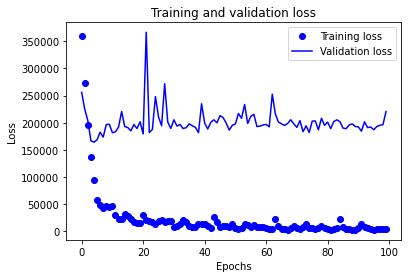

In [281]:
history_dict = history.history
loss = history.history['loss'] 
val_loss = history.history['val_loss']
plt.plot(range(epochs), loss, 'bo', label='Training loss')
plt.plot(range(epochs), val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [282]:
y_pred.shape

(1960, 1)

In [283]:
X_test.shape

(1960, 3102)

In [284]:
sales_pred = pd.DataFrame(y_pred, y_test, columns=['Sales_pred'])

In [285]:
sales_pred.reset_index()

,Sales,Sales_pred
0,526.450,395.183777
1,703.710,1761.584717
2,360.712,62.497887
3,26.720,20.001976
4,1.938,8.745277
...,...,...
1955,78.759,147.847473
1956,20.860,15.712870
1957,7.310,12.813688
1958,105.686,419.442047


In [286]:
from tensorflow.keras import callbacks

earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        patience = 5, 
                                        restore_best_weights = True)

# Train and evaluate 
batch_size = 16
epochs = 100

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, y_test),
                   callbacks=[earlystopping,callbacks.ReduceLROnPlateau()])

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score)
#print('Test accuracy:', score[1])

Train on 7840 samples, validate on 1960 samples
Epoch 1/100
7840/7840 [==============================] - 9s 1ms/sample - loss: 8934.0356 - val_loss: 192162.9748
Epoch 2/100
7840/7840 [==============================] - 7s 935us/sample - loss: 2759.8304 - val_loss: 194673.2887
Epoch 3/100
7840/7840 [==============================] - 8s 958us/sample - loss: 2691.2490 - val_loss: 186620.5744
Epoch 4/100
7840/7840 [==============================] - 7s 878us/sample - loss: 2460.4837 - val_loss: 201082.9495
Epoch 5/100
7840/7840 [==============================] - 7s 854us/sample - loss: 5116.1022 - val_loss: 190731.0660
Epoch 6/100
7840/7840 [==============================] - 7s 857us/sample - loss: 11681.7559 - val_loss: 197806.1105
Epoch 7/100
7840/7840 [==============================] - 7s 847us/sample - loss: 7931.7477 - val_loss: 185850.9065
Epoch 8/100
7840/7840 [==============================] - 7s 846us/sample - loss: 6477.6973 - val_loss: 186771.9230
Epoch 9/100
7840/7840 [==========

In [287]:
# predict and get r2_score
y_pred = model.predict(X_test)
test_r2 = r2_score(y_test, y_pred)
print('Test R2_Score: {:.5f}'.format(test_r2) )

Test R2_Score: 0.45156


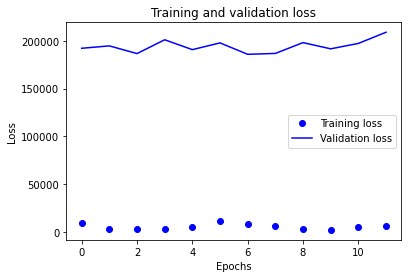

In [288]:
history_dict = history.history
loss = history.history['loss'] 
val_loss = history.history['val_loss']
plt.plot( loss, 'bo', label='Training loss')
plt.plot( val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [289]:
sales_pred = pd.DataFrame(y_pred, y_test, columns=['Sales_pred'])

In [290]:
sales_pred.reset_index()

,Sales,Sales_pred
0,526.450,463.101715
1,703.710,1643.713135
2,360.712,58.345879
3,26.720,35.068474
4,1.938,6.669884
...,...,...
1955,78.759,104.725990
1956,20.860,19.988029
1957,7.310,12.118319
1958,105.686,299.006927


In [291]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        patience = 5, 
                                        restore_best_weights = True)

# Train and evaluate 
batch_size = 16
epochs = 100

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, y_test),
                   callbacks=[earlystopping])

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score)
#print('Test accuracy:', score[1])

Train on 7840 samples, validate on 1960 samples
Epoch 1/100
7840/7840 [==============================] - 6s 827us/sample - loss: 8400.1003 - val_loss: 200400.0555
Epoch 2/100
7840/7840 [==============================] - 6s 815us/sample - loss: 5900.5971 - val_loss: 200348.7652
Epoch 3/100
7840/7840 [==============================] - 6s 823us/sample - loss: 3154.5192 - val_loss: 195162.8751
Epoch 4/100
7840/7840 [==============================] - 6s 812us/sample - loss: 2994.5075 - val_loss: 198963.9384
Epoch 5/100
7840/7840 [==============================] - 6s 814us/sample - loss: 2761.3266 - val_loss: 189281.9180
Epoch 6/100
7840/7840 [==============================] - 6s 821us/sample - loss: 3346.7564 - val_loss: 202363.1948
Epoch 7/100
7840/7840 [==============================] - 7s 829us/sample - loss: 5195.0262 - val_loss: 200103.8964
Epoch 8/100
7840/7840 [==============================] - 6s 827us/sample - loss: 9014.4023 - val_loss: 187031.8087
Epoch 9/100
7840/7840 [=========

In [292]:
# predict and get r2_score
y_pred = model.predict(X_test)
test_r2 = r2_score(y_test, y_pred)
print('Test R2_Score: {:.5f}'.format(test_r2) )

Test R2_Score: 0.44807


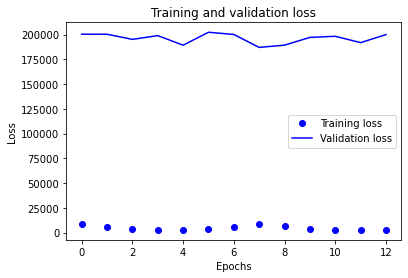

In [293]:
history_dict = history.history
loss = history.history['loss'] 
val_loss = history.history['val_loss']
plt.plot( loss, 'bo', label='Training loss')
plt.plot( val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [294]:
sales_pred = pd.DataFrame(y_pred, y_test, columns=['Sales_pred'])
sales_pred.reset_index()

,Sales,Sales_pred
0,526.450,499.373932
1,703.710,1561.874146
2,360.712,106.114014
3,26.720,33.235367
4,1.938,8.097678
...,...,...
1955,78.759,173.331512
1956,20.860,21.883991
1957,7.310,17.029051
1958,105.686,349.897644


In [295]:
# functional api

In [296]:
inputs = tf.keras.Input(shape=(X_train.shape[1],))

In [297]:
x = Dense(1024, activation='relu')(inputs)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
outputs = Dense(1, activation='linear')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()
model.compile(loss='mse',
              optimizer='adam')


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3102)]            0         
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              3177472   
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 1025      
Total params: 6,327,297
Trainable params: 6,327,297
Non-trainable params: 0
___________________________________________________

In [298]:
# Train and evaluate 
batch_size = 16
epochs = 100

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, y_test),
                   callbacks=[earlystopping, callbacks.ReduceLROnPlateau()])

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score)

Train on 7840 samples, validate on 1960 samples
Epoch 1/100
7840/7840 [==============================] - 39s 5ms/sample - loss: 345588.4742 - val_loss: 234570.4665
Epoch 2/100
7840/7840 [==============================] - 36s 5ms/sample - loss: 216892.9390 - val_loss: 231747.1469
Epoch 3/100
7840/7840 [==============================] - 36s 5ms/sample - loss: 188733.5902 - val_loss: 201692.1961
Epoch 4/100
7840/7840 [==============================] - 35s 5ms/sample - loss: 183308.1939 - val_loss: 217947.7323
Epoch 5/100
7840/7840 [==============================] - 36s 5ms/sample - loss: 138044.0046 - val_loss: 194626.0174
Epoch 6/100
7840/7840 [==============================] - 35s 5ms/sample - loss: 77403.8473 - val_loss: 182032.5020
Epoch 7/100
7840/7840 [==============================] - 35s 4ms/sample - loss: 72366.5679 - val_loss: 184239.8606
Epoch 8/100
7840/7840 [==============================] - 35s 4ms/sample - loss: 72873.5597 - val_loss: 193762.1961
Epoch 9/100
7840/7840 [====

In [299]:
# predict and get r2_score
y_pred = model.predict(X_test)
test_r2 = r2_score(y_test, y_pred)
print('Test R2_Score: {:.5f}'.format(test_r2) )

Test R2_Score: 0.46283


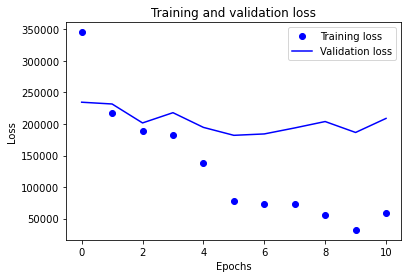

In [300]:
history_dict = history.history
loss = history.history['loss'] 
val_loss = history.history['val_loss']
plt.plot( loss, 'bo', label='Training loss')
plt.plot( val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [301]:
sales_pred = pd.DataFrame(y_pred, y_test, columns=['Sales_pred'])
sales_pred = sales_pred.reset_index()
sales_pred

,Sales,Sales_pred
0,526.450,272.107513
1,703.710,419.689789
2,360.712,143.970505
3,26.720,48.753658
4,1.938,30.791883
...,...,...
1955,78.759,55.460251
1956,20.860,39.606621
1957,7.310,15.971228
1958,105.686,222.452118


In [302]:
sales_pred.describe()

,Sales,Sales_pred
count,1960.000000,1960.000000
mean,227.644596,191.823303
std,582.274953,385.177185
min,0.876000,4.658811
25%,17.370000,30.707983
50%,54.898000,60.281864
75%,200.388500,182.613201
max,10499.970000,6991.486816


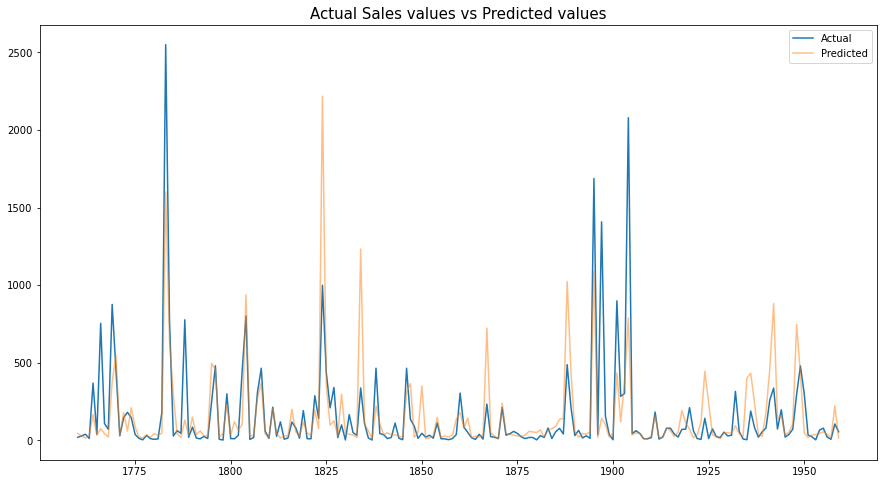

In [303]:
#plot last 200 values and predictions
plt.figure(figsize=(15,8))
sales_pred['Sales'][-200:].plot(label='Actual')
sales_pred['Sales_pred'][-200:].plot(alpha=0.5,label='Predicted')
plt.title('Actual Sales values vs Predicted values', size=15)
plt.legend();